# Seasonal ARIMA 모형 추정의 예

## 대기중 이산화탄소 농도 예측

다음은 대기중 이산화탄소 농도에 대한 시계열 자료이다. 이 시계열은 뚜렷한 계절성을 보이고 있다.

In [163]:
data = sm.datasets.get_rdataset("co2")
df = data.data

def yearfraction2datetime(yearfraction, startyear=0):
    import datetime, dateutil
    year = int(yearfraction) + startyear
    month = int(round(12 * (yearfraction - year)))
    delta = dateutil.relativedelta.relativedelta(months=month)
    date = datetime.datetime(year, 1, 1) + delta
    return date

df["datetime"] = df.time.map(yearfraction2datetime)
df["month"] = df.datetime.dt.month
df.tail()

,time,co2,datetime,month
463,1997.583333,362.57,1997-08-01,8
464,1997.666667,360.24,1997-09-01,9
465,1997.750000,360.83,1997-10-01,10
466,1997.833333,362.49,1997-11-01,11
467,1997.916667,364.34,1997-12-01,12


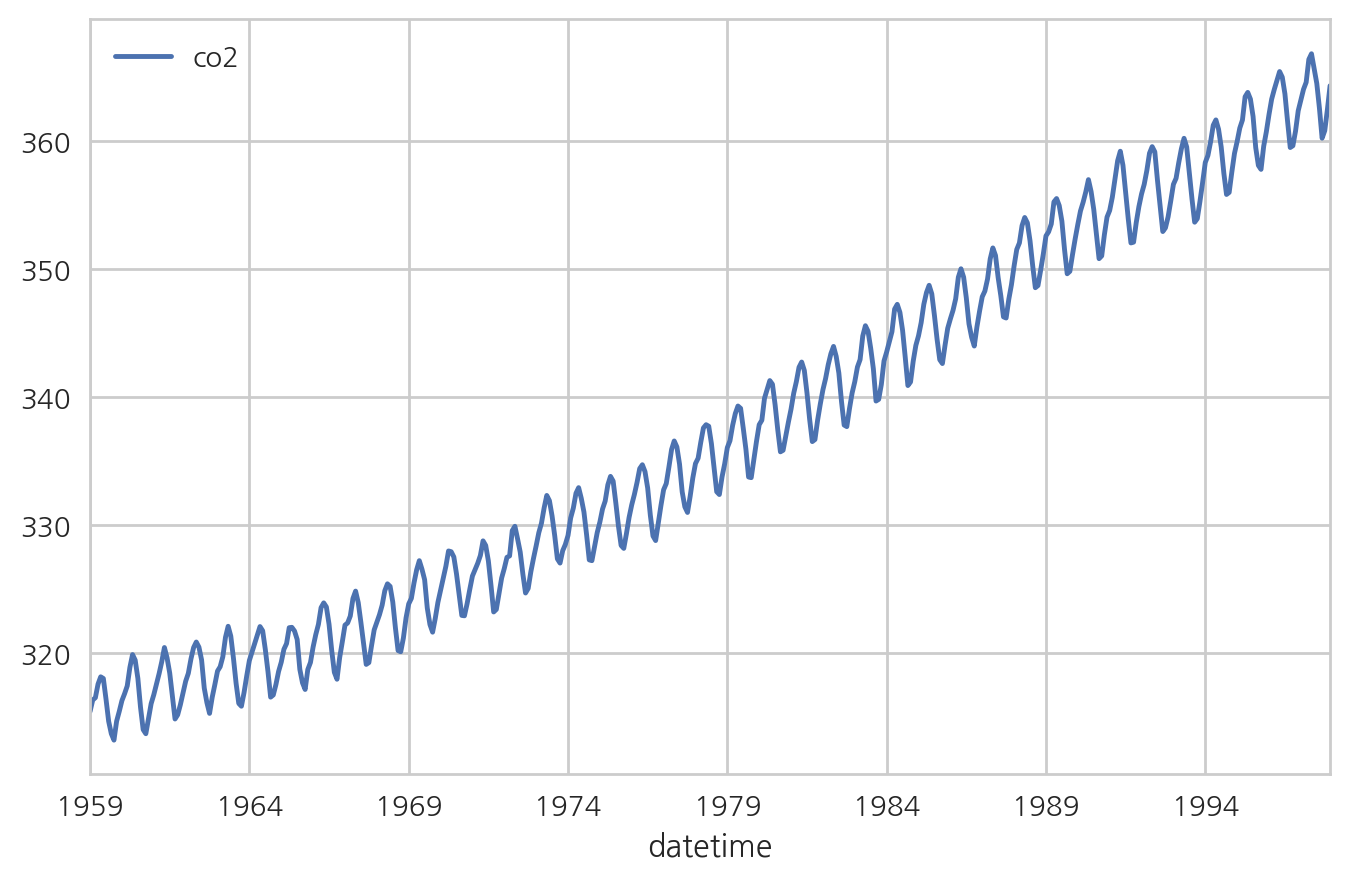

In [164]:
df.plot(x="datetime", y="co2")
plt.show()

[`SARIMAX`](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) 클래스 이용하면 Multiplicated SARIMA(p,d,q)x(P,D,Q,s) 모형에 대한 추정 및 예측이 가능하다. 

클래스 인스턴스를 생성하기 위해서는 `order` 인수에 (p,d,q) 튜플을, `seasonal_order` 인수에 (P,D,Q,s) 튜플을 넣는다.

`SARIMAX` 의 `fit` 메서드는 모수를 추정하여 그 결과를 `SARIMAXResult` 클래스 인스턴스로 반환한다.

우선 Multiplicated가 아닌 단순 Seasonal ARIMA 모형을 사용해보자.

In [165]:
m1 = sm.tsa.SARIMAX(df.co2.values, order=(0,0,0), seasonal_order=(1,1,2,12))
r1 = m1.fit()
print(r1.summary())

                            Statespace Model Results                            
Dep. Variable:                        y   No. Observations:                  468
Model:             SARIMAX(1, 1, 2, 12)   Log Likelihood                -443.176
Date:                  Fri, 28 Jul 2017   AIC                            894.353
Time:                          15:23:38   BIC                            910.947
Sample:                               0   HQIC                           900.883
                                  - 468                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9970      0.003    315.331      0.000       0.991       1.003
ma.S.L12      -0.9227      0.052    -17.596      0.000      -1.025      -0.820
ma.S.L24       0.0771      0.052    

이번에는 단순 차분한 결과를 12시간단위 주기로 계절-차분을 하여 자기상관함수를 살펴본다.

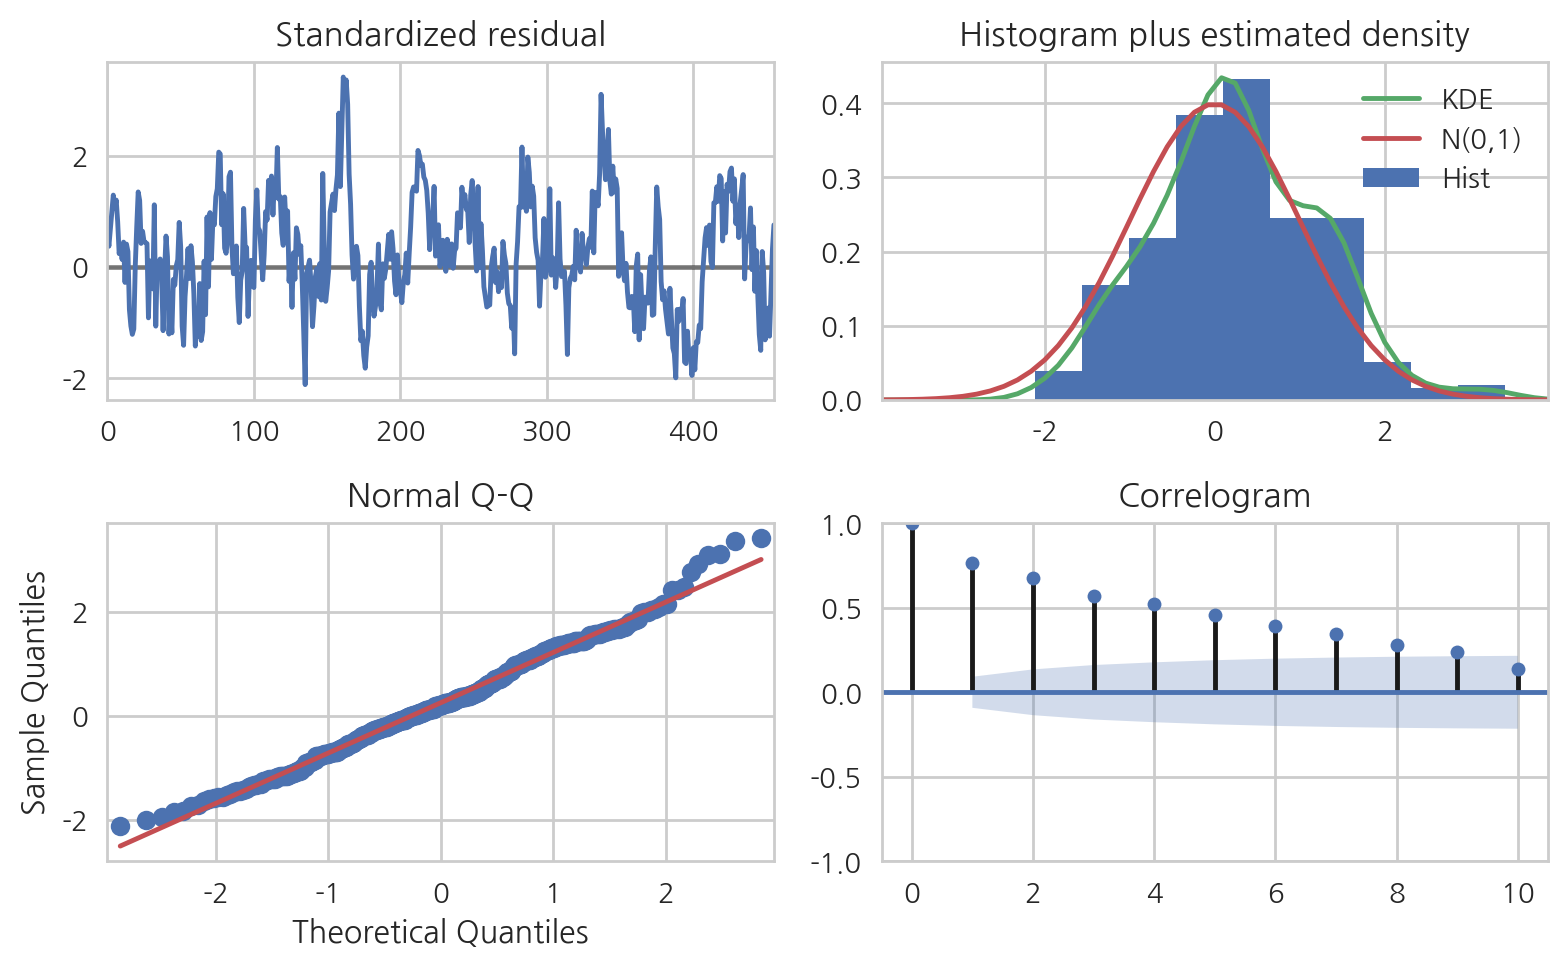

In [166]:
r1.plot_diagnostics()
plt.tight_layout()
plt.show()

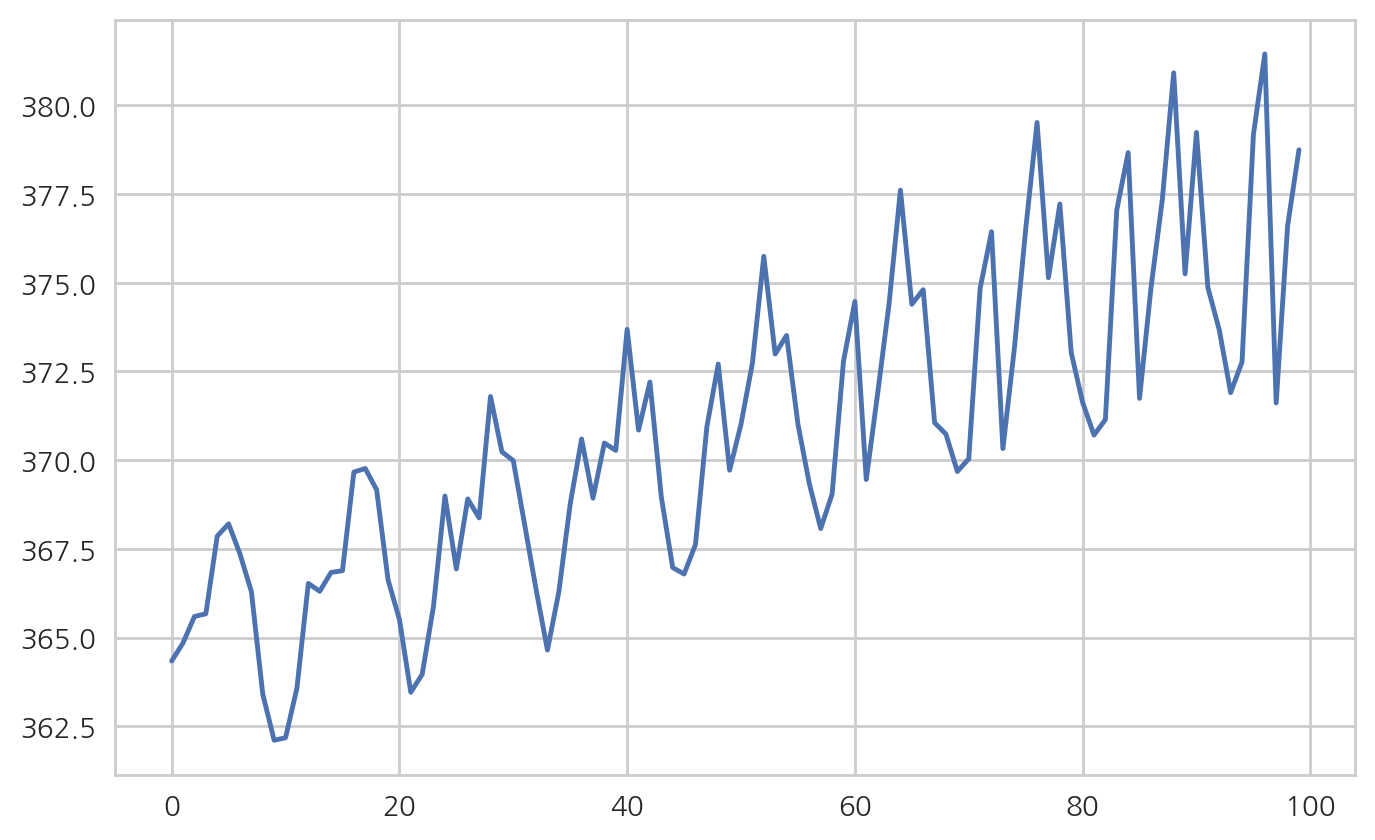

In [167]:
plt.plot(r1.simulate(100, initial_state=r1.filtered_state[:,-1]))
plt.show()

이번에는 Multiplicated Seasonal ARIMA 모형을 위해 단순 차분을 한 결과의 ACF와 PACF를 살펴보자.

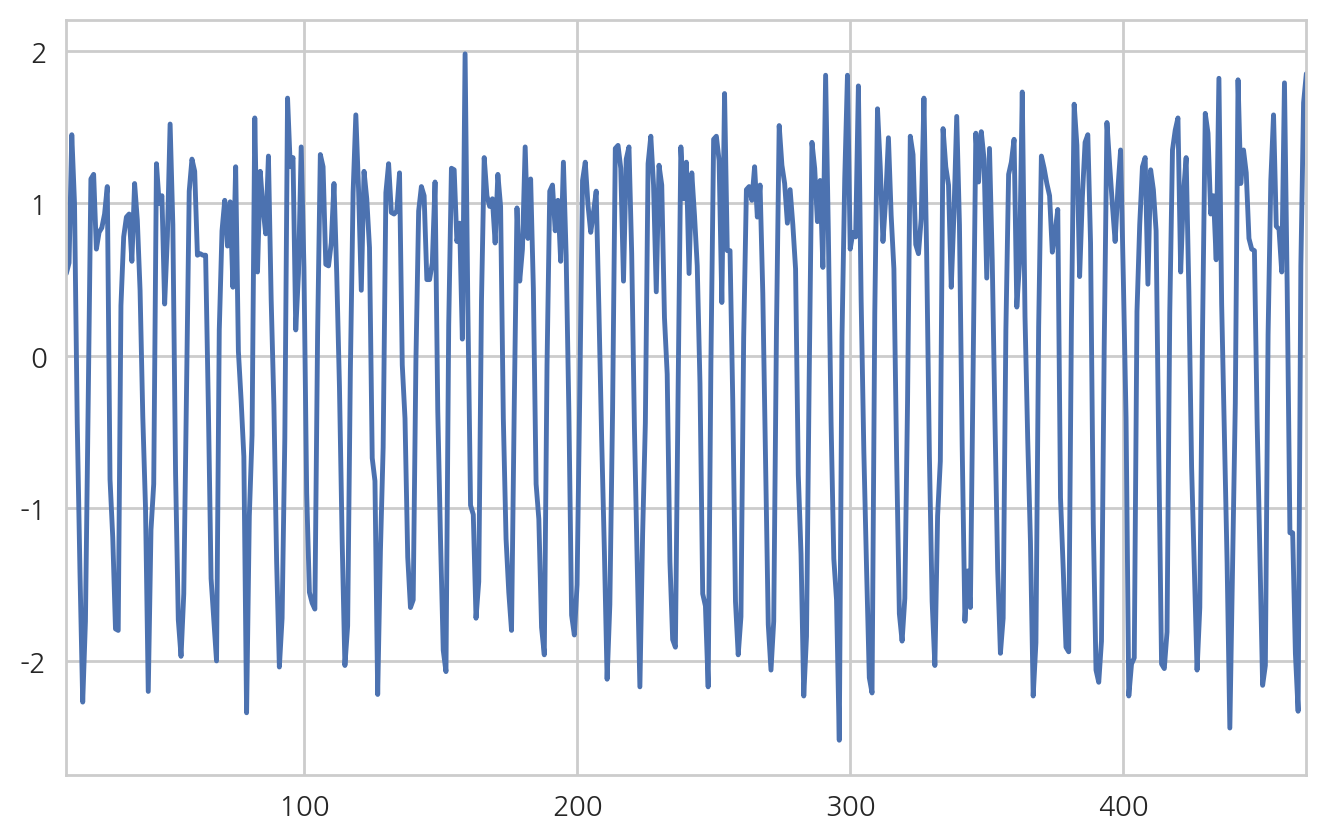

In [168]:
df["y2"] = df["co2"].diff()
df3 = df.iloc[13:, :]
df3.y2.plot()
plt.show()

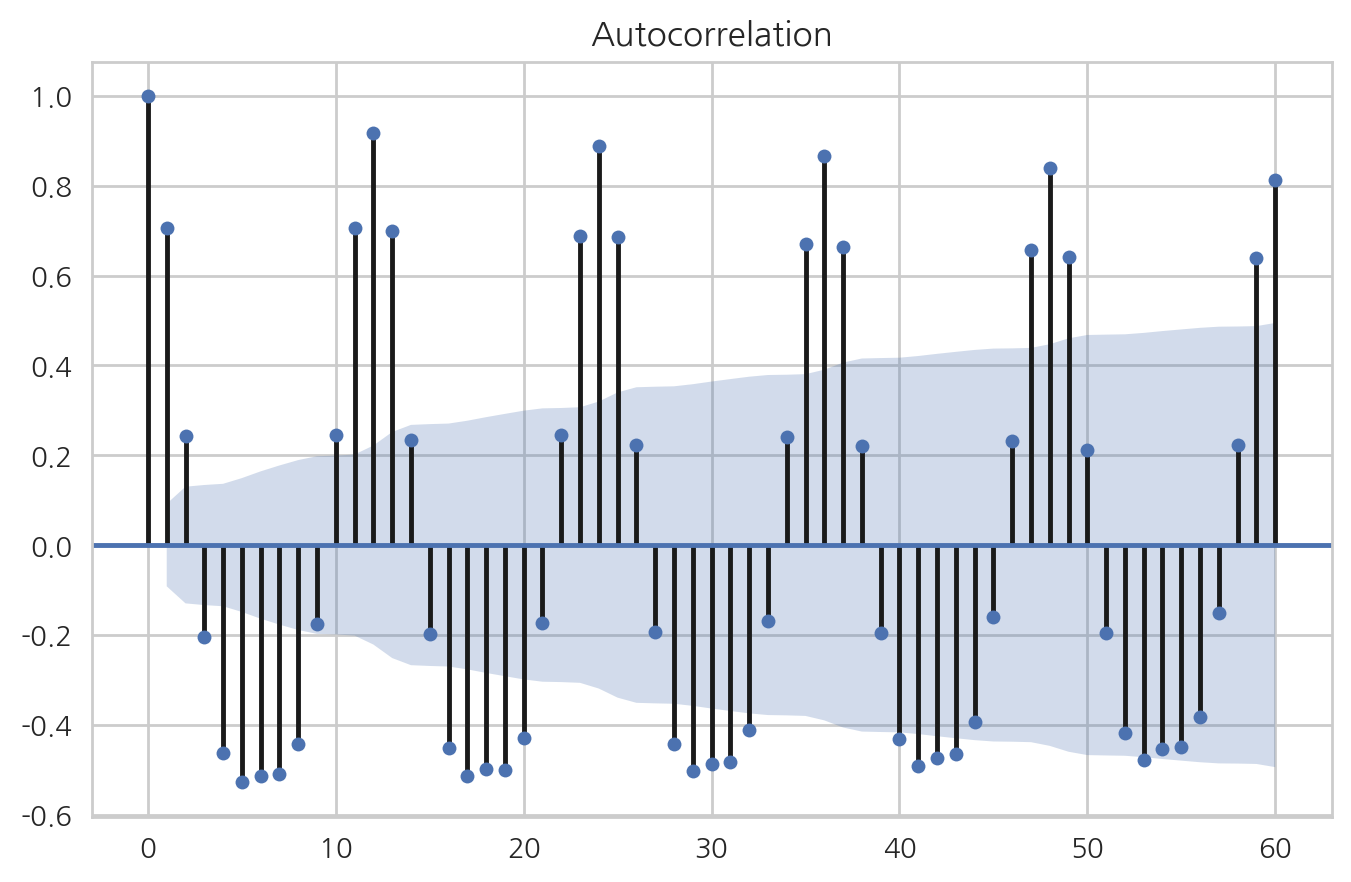

In [169]:
sm.tsa.graphics.plot_acf(df3.y2, lags=60)
plt.show()

In [170]:
m2 = sm.tsa.SARIMAX(df.co2.values, order=(1,1,1), seasonal_order=(1,1,1,12))
r2 = m2.fit()
print(r2.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  468
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -84.882
Date:                            Fri, 28 Jul 2017   AIC                            179.763
Time:                                    15:23:43   BIC                            200.506
Sample:                                         0   HQIC                           187.925
                                            - 468                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2454      0.119      2.064      0.039       0.012       0.478
ma.L1         -0.5746      0.103   

두 모형의 잔차를 비교하면 다음과 같다.

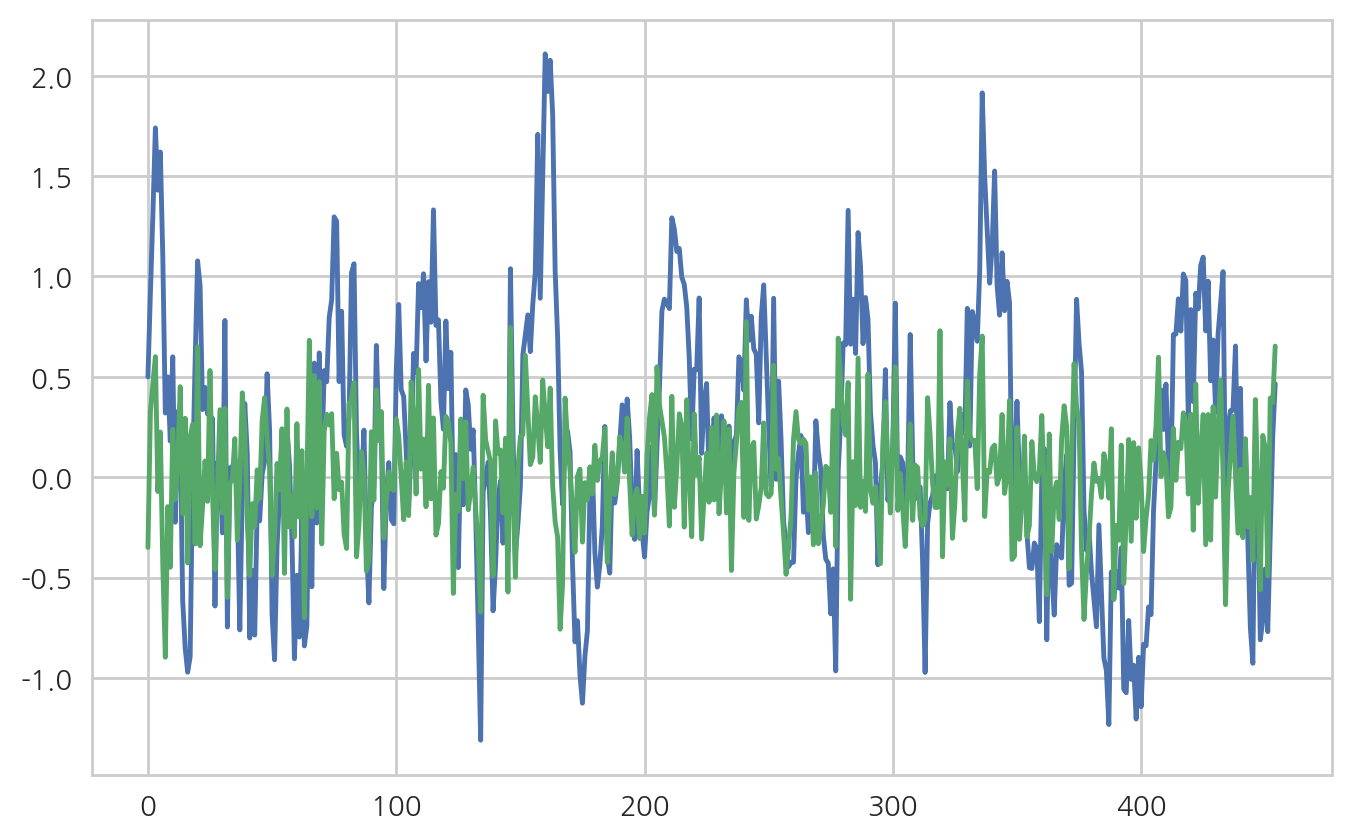

In [171]:
plt.plot(r1.resid[13:], color='b')
plt.plot(r2.resid[13:], color='g')
plt.show()

두 모형의 잔차의 정규성과 자기상관계수 함수는 `SARIMAXResult` 클래스의 `plot_diagnostics` 메서드로 살펴볼 수 있다.

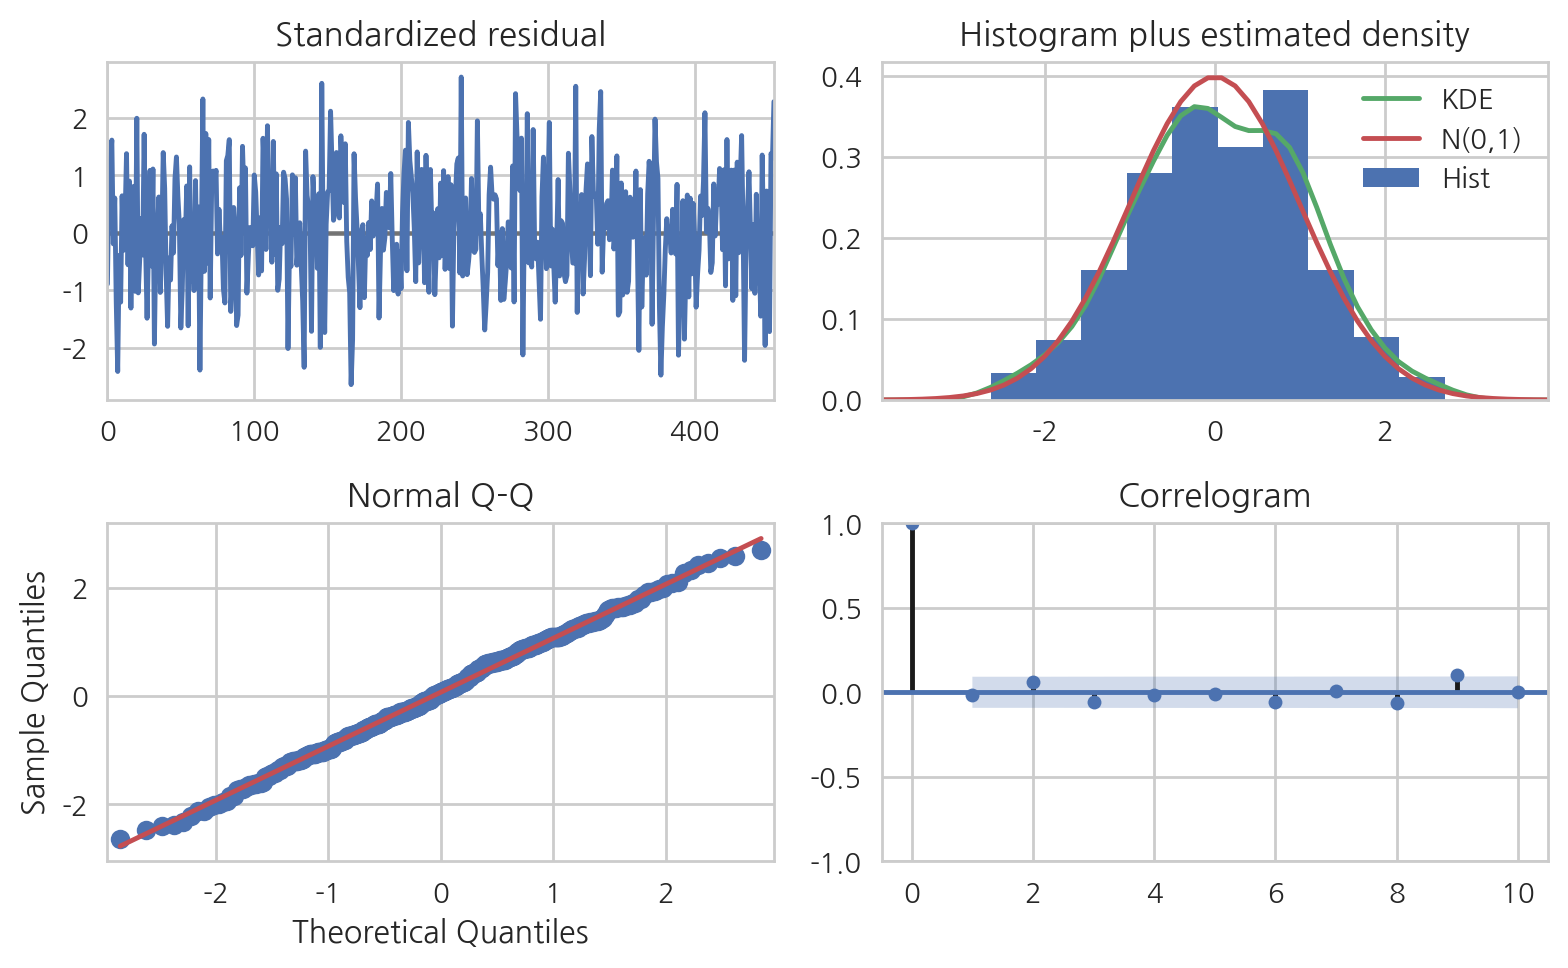

In [172]:
r2.plot_diagnostics()
plt.tight_layout()
plt.show()

## 시뮬레이션

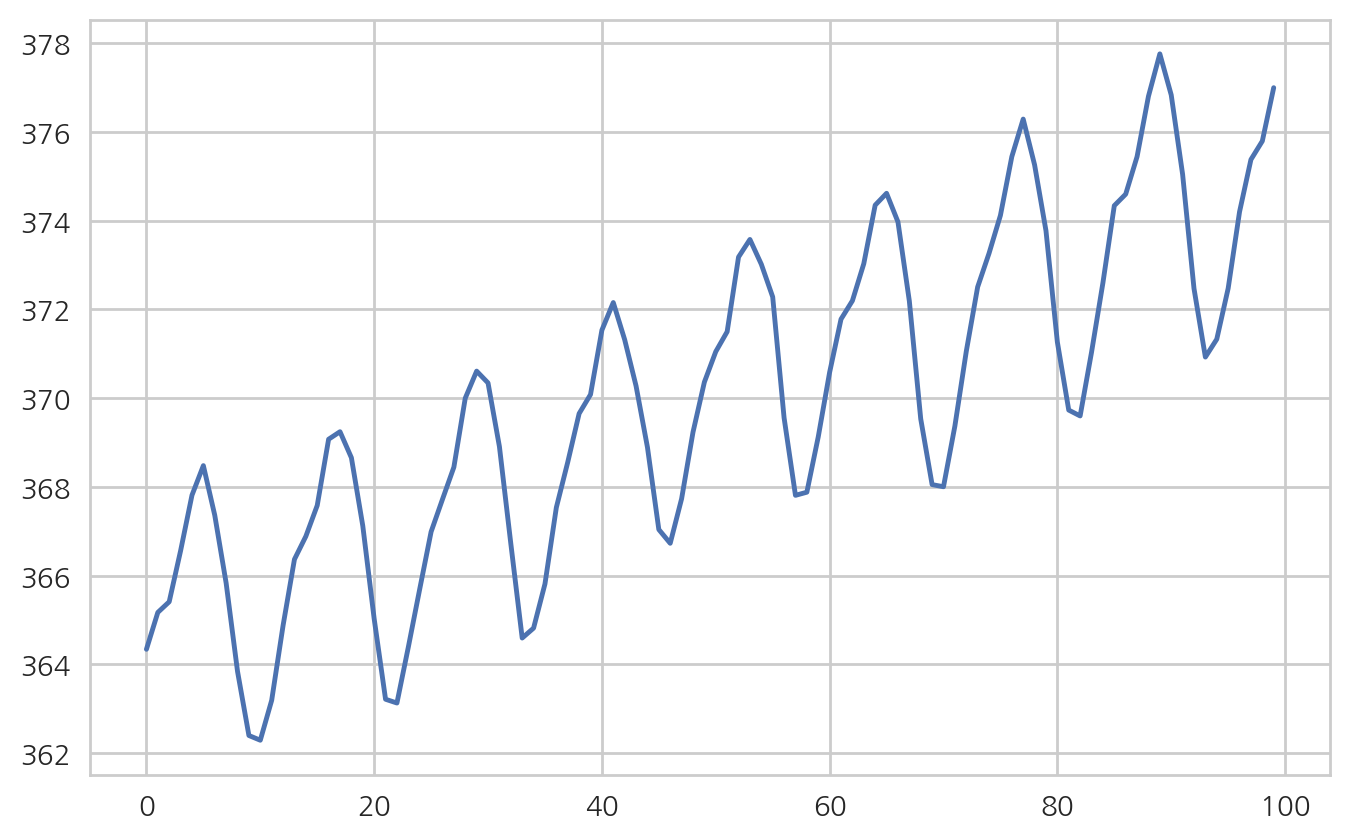

In [173]:
plt.plot(r2.simulate(100, initial_state=r2.filtered_state[:,-1]))
plt.show()

다음 플롯은 추정된 모형을 사용하여 시계열을 시뮬레이션 한 결과이다. Seasonal 모형의 경우에는 각 season 별로 거의 독립적이므로 season cycle의 형태는 초기 상태에 좌우된다. 따라서 기존의 초기 상태값을 그래도 사용하였다.

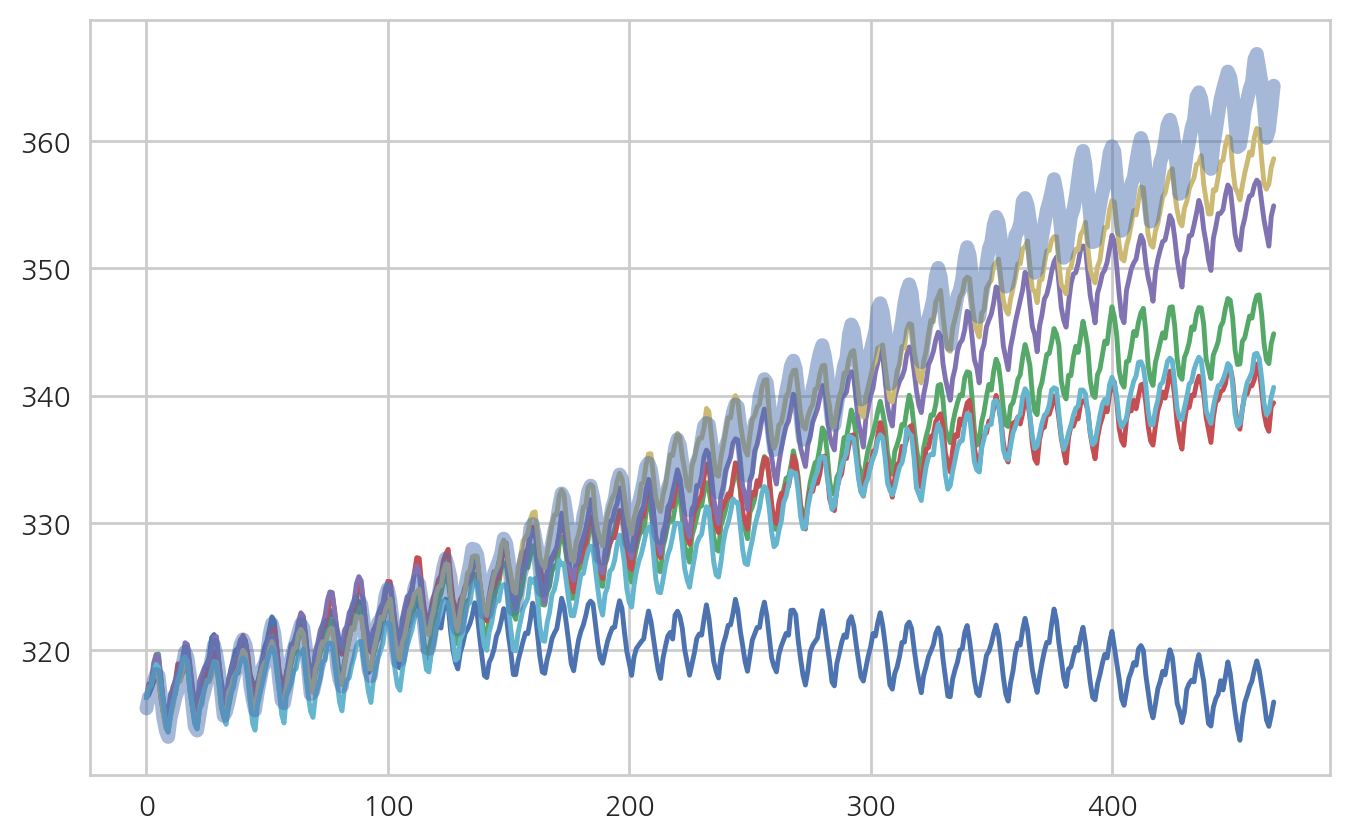

In [174]:
np.random.seed(0)
initial_state = r2.filtered_state[:,12]
for i in range(6):
    plt.plot(r2.simulate(len(df.co2), initial_state=initial_state))
plt.plot(df.co2.values, lw=5, alpha=0.5)
plt.show()

## 예측

Multiplicated SARIMA모형도 일반적인 ARIMA 모형에 속하기 때문에 ARIMA 모형의 예측 알고리즘을 그대로 사용한다. 

In [175]:
horizon = 120
pred = r2.get_prediction(start=len(df), end=len(df) + horizon)
s = df.co2.values.copy()
s[:-1] = np.nan
s = np.hstack([s, pred.predicted_mean])
ci = pred.conf_int(alpha=0.05)

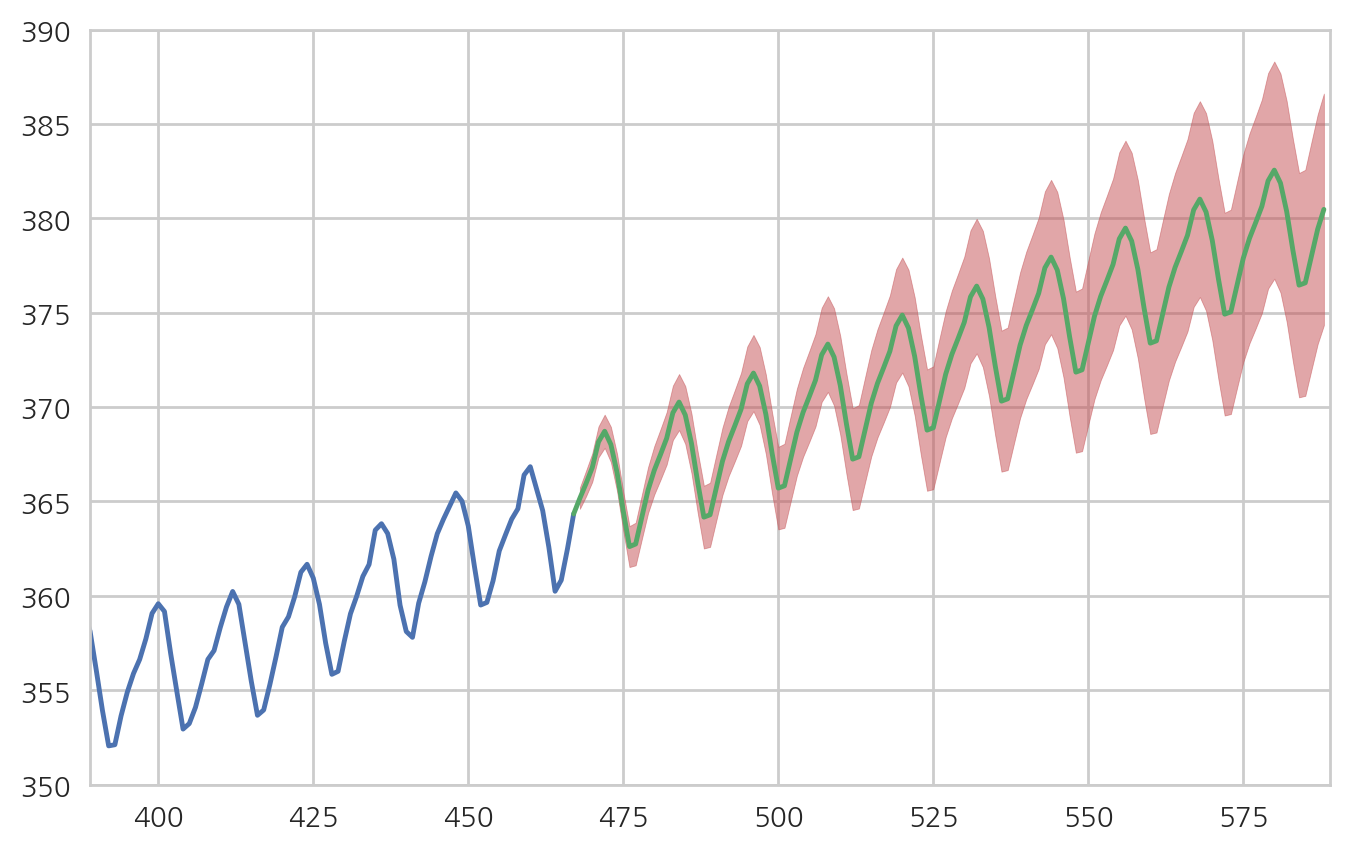

In [176]:
plt.plot(df.co2)
plt.plot(s)
plt.fill_between(ci.index + len(df), ci["lower y"], ci["upper y"], color='r', alpha=0.5)
plt.xlim(len(s) - 200, len(s))
plt.ylim(350, 390)
plt.show()

### Trend

In [235]:
m3 = sm.tsa.SARIMAX(df.co2.values, trend='c',
                    order=(1,0,1), seasonal_order=(1,0,1,12),
                    enforce_stationarity=False, enforce_invertibility=False)
r3 = m3.fit()
print(r3.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  468
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -142.492
Date:                            Fri, 28 Jul 2017   AIC                            296.984
Time:                                    15:35:15   BIC                            321.875
Sample:                                         0   HQIC                           306.779
                                            - 468                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.7112      0.185     -3.834      0.000      -1.075      -0.348
ar.L1          0.8091      0.032   

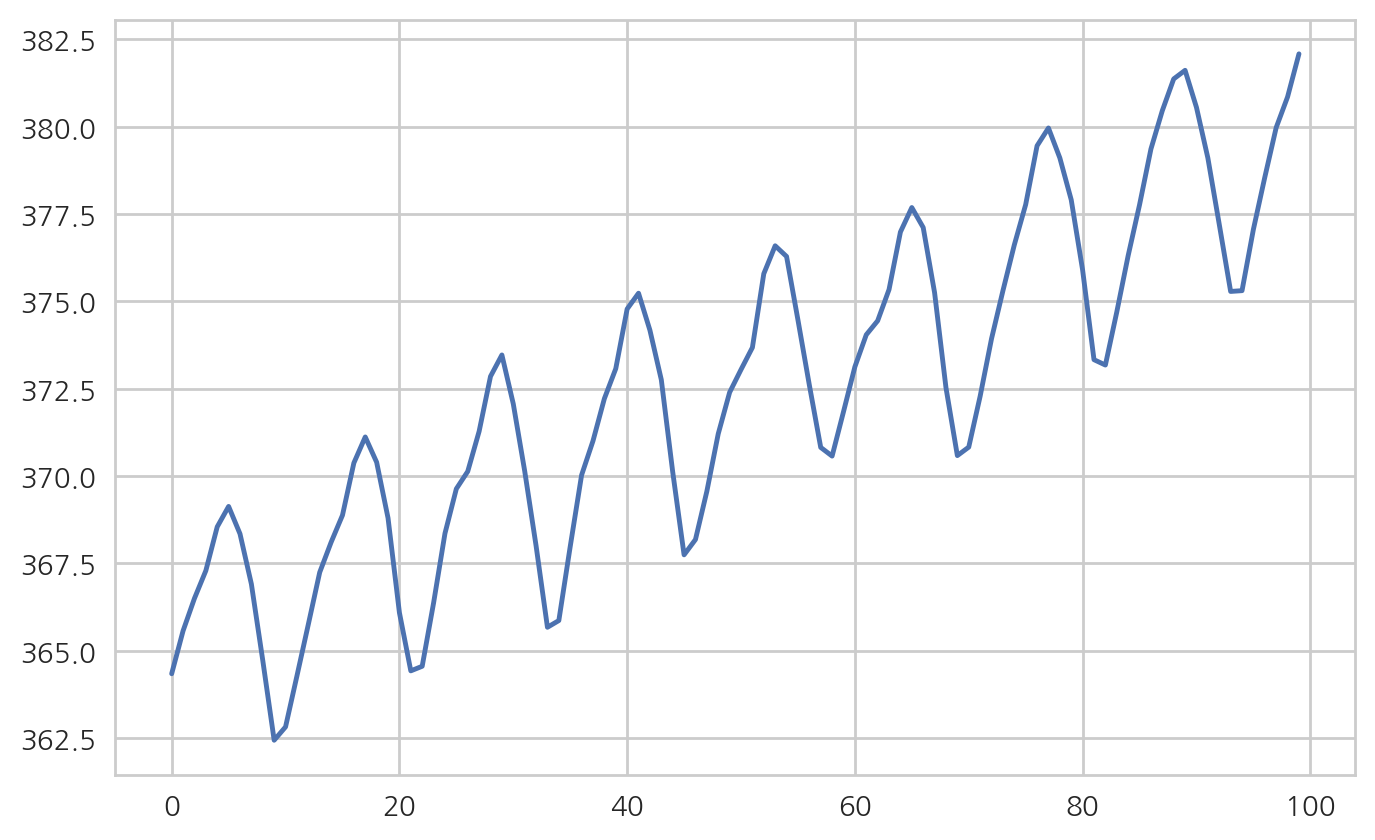

In [236]:
plt.plot(r3.simulate(100, initial_state=r3.filtered_state[:,-1]))
plt.show()

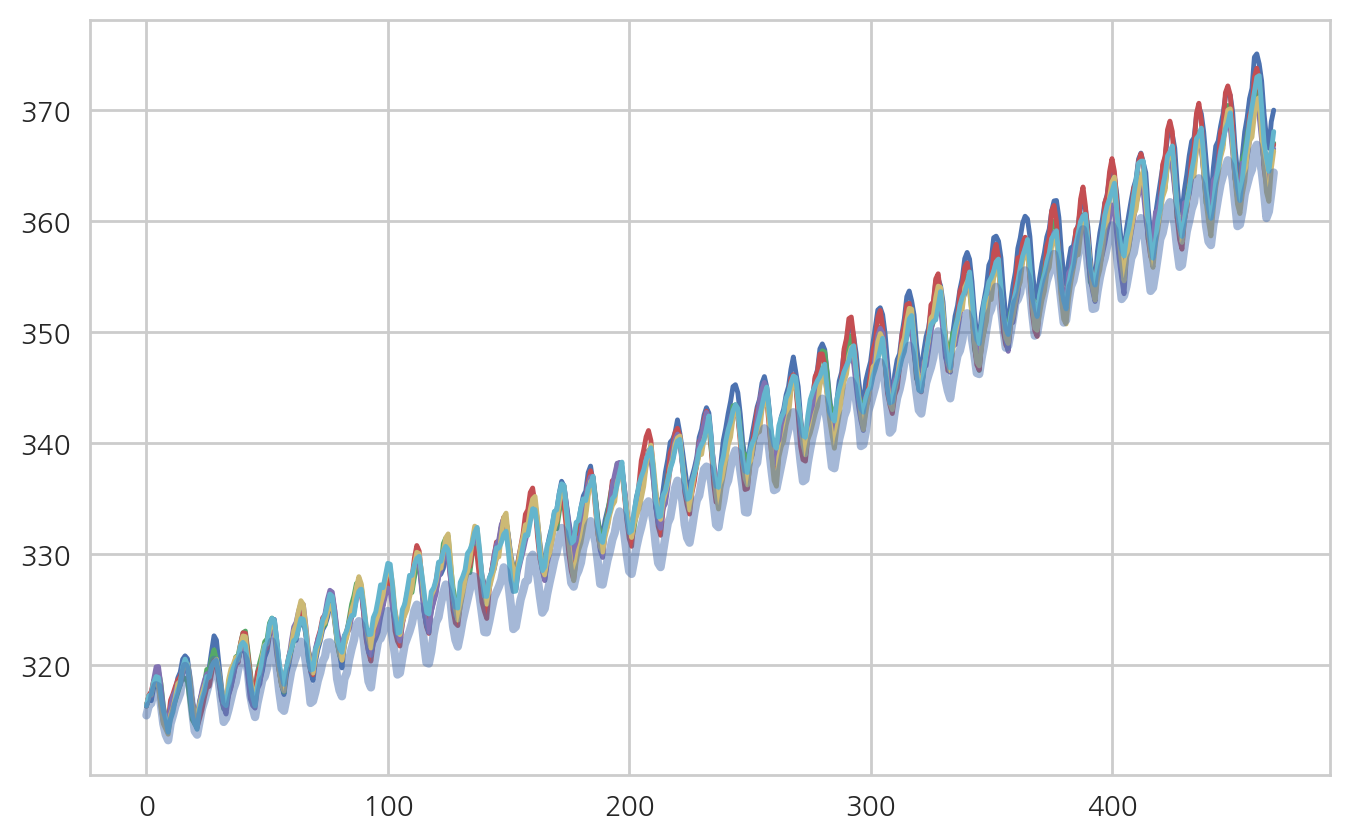

In [238]:
np.random.seed(0)
initial_state = r3.filtered_state[:,12]
for i in range(6):
    plt.plot(r3.simulate(len(df.co2), initial_state=initial_state))
plt.plot(df.co2.values, lw=3, alpha=0.5)
plt.show()

## 호흡기질환 사망자 수

In [240]:
data = sm.datasets.get_rdataset("deaths", "MASS")
df = data.data
df["datetime"] = df.time.map(yearfraction2datetime)
df["month"] = df.datetime.dt.month
df.tail()

,time,deaths,datetime,month
67,1979.583333,1354,1979-08-01,8
68,1979.666667,1333,1979-09-01,9
69,1979.750000,1492,1979-10-01,10
70,1979.833333,1781,1979-11-01,11
71,1979.916667,1915,1979-12-01,12


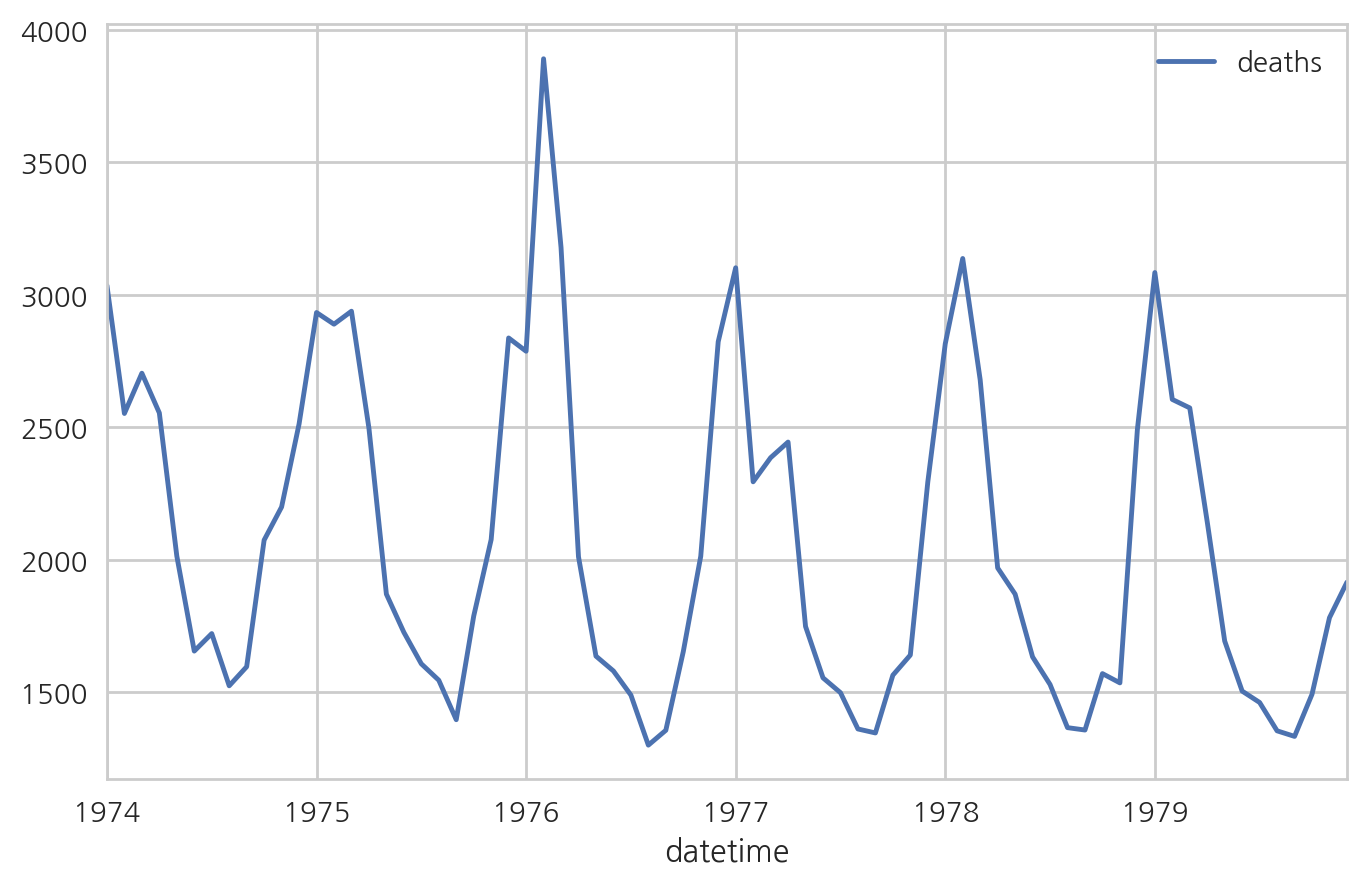

In [241]:
df.plot(x="datetime", y="deaths")
plt.show()

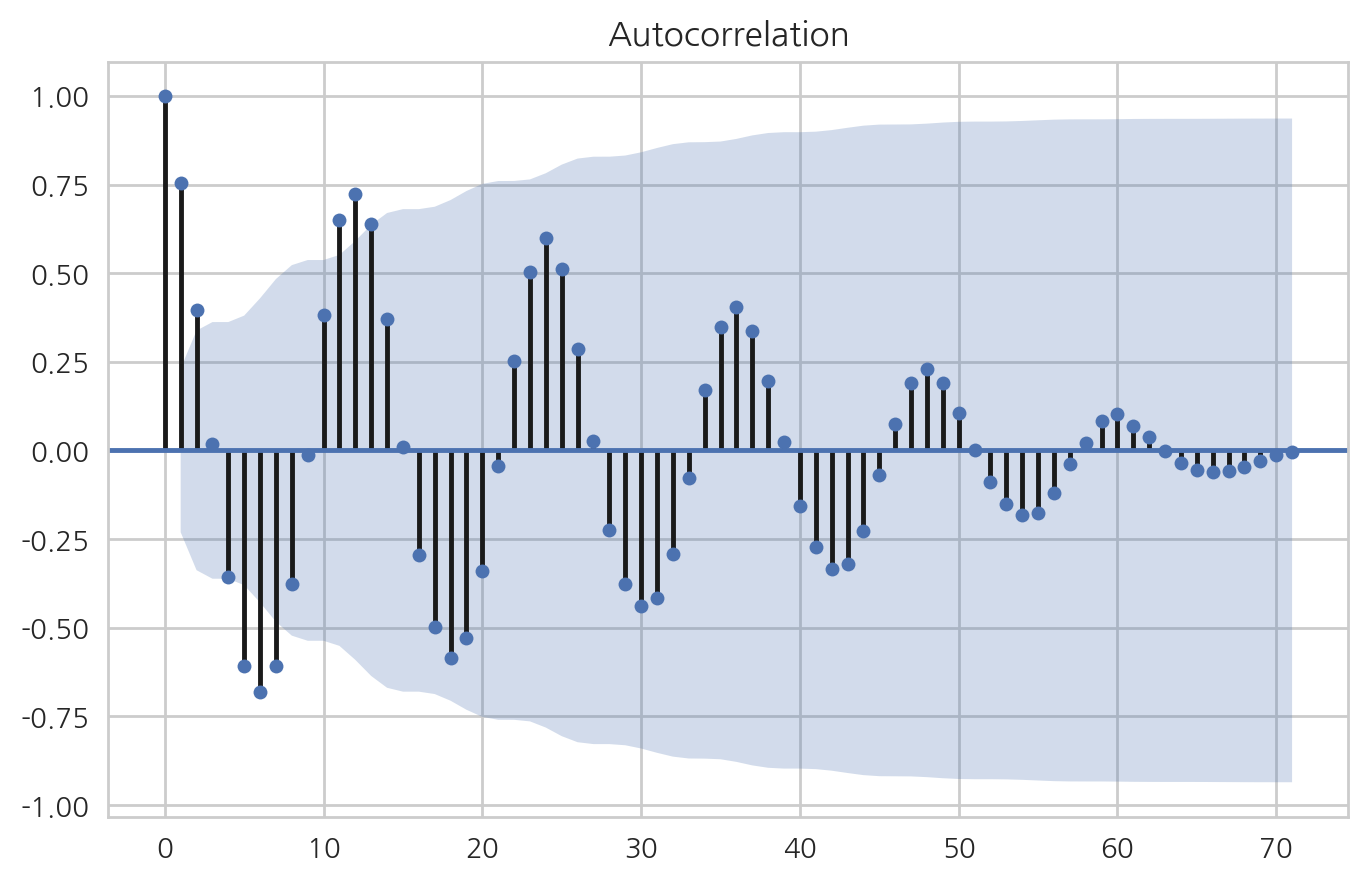

In [242]:
sm.tsa.graphics.plot_acf(df.deaths)
plt.show()

In [243]:
from patsy import dmatrix

In [248]:
m = sm.tsa.SARIMAX(df.deaths.values, dmatrix("C(month) + 0", data=df),
                   order=(1,0,1), seasonal_order=(1,0,1,12))
r = m.fit()
print(r.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   72
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -478.701
Date:                            Fri, 28 Jul 2017   AIC                            991.401
Time:                                    15:37:32   BIC                           1030.105
Sample:                                         0   HQIC                          1006.809
                                             - 72                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          2918.1077    115.442     25.278      0.000    2691.845    3144.371
x2          2935.4705    108.313   

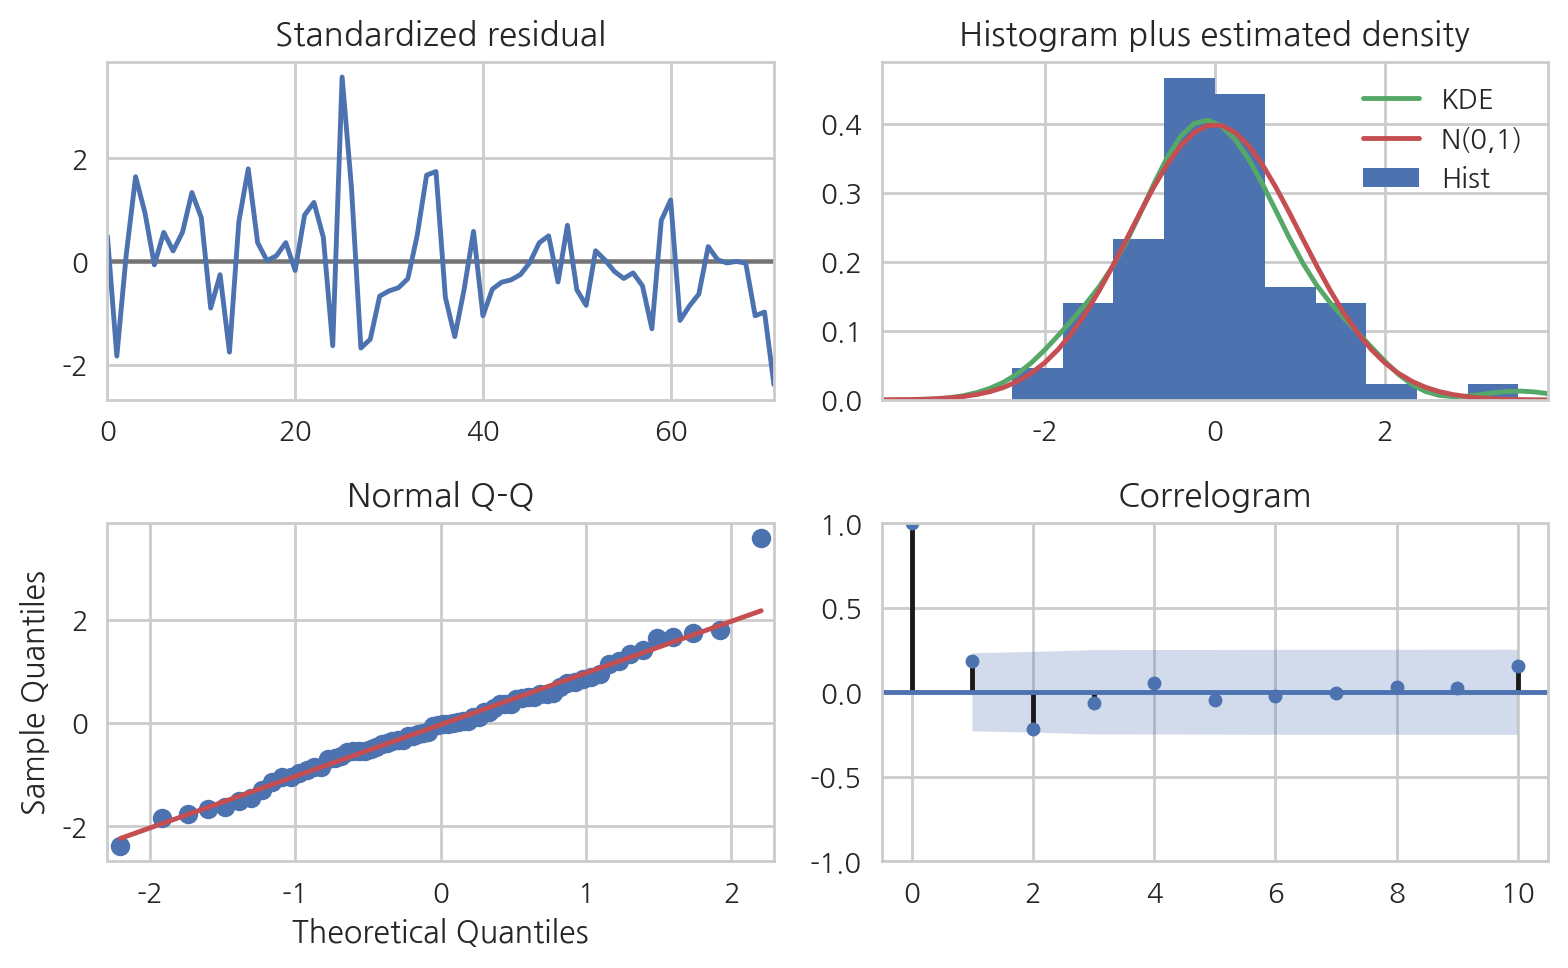

In [249]:
r.plot_diagnostics()
plt.tight_layout()
plt.show()

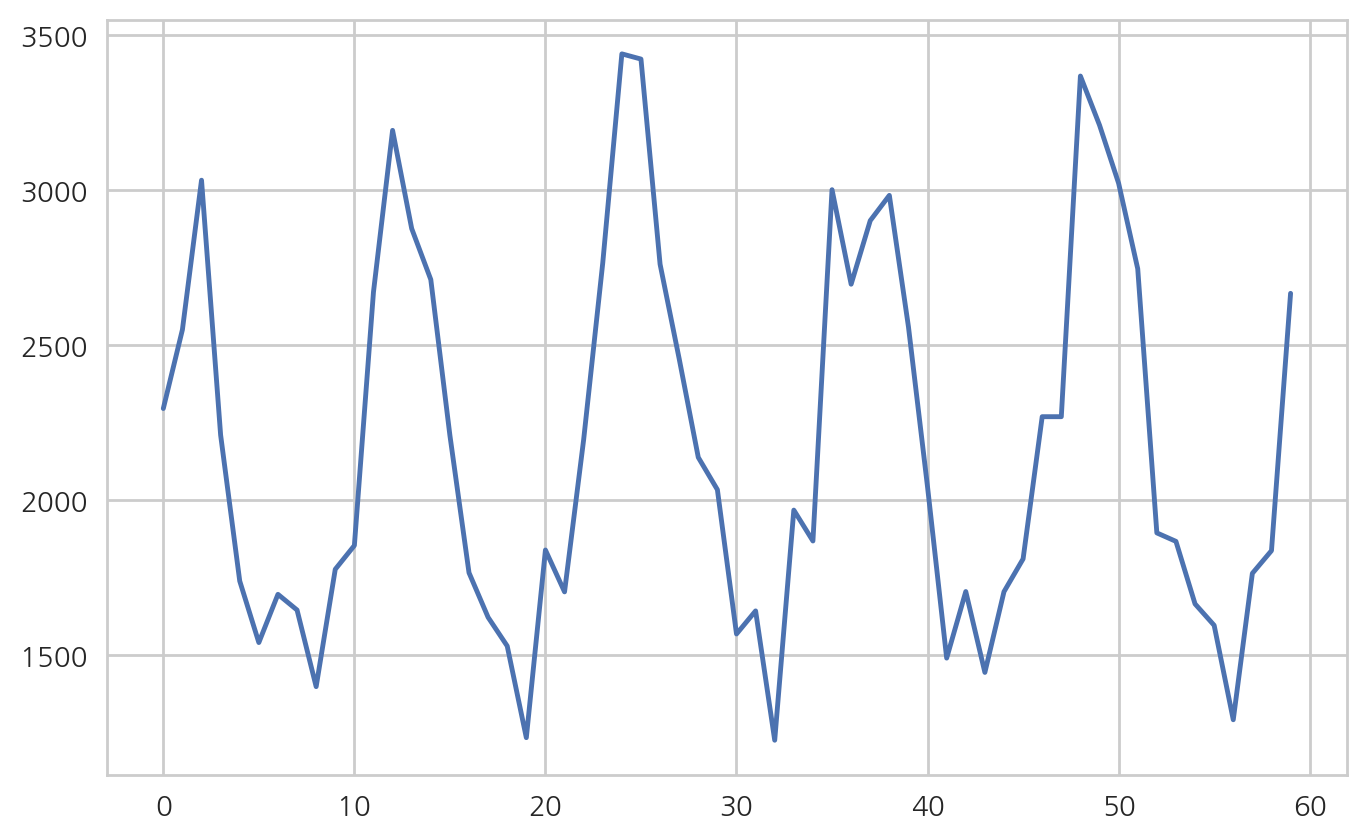

In [250]:
plt.plot(r.simulate(60, initial_state=r.filtered_state[:,-1]))
plt.show()

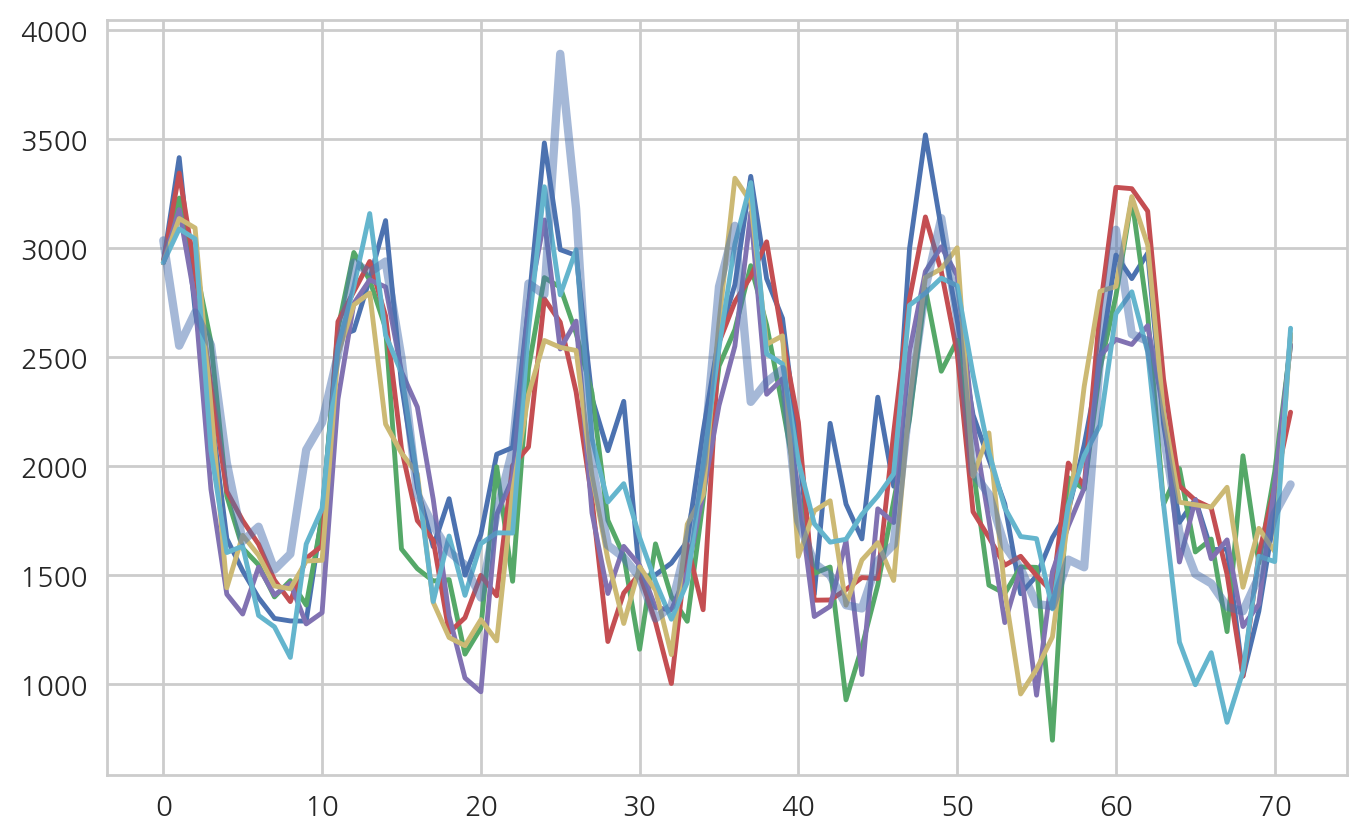

In [251]:
np.random.seed(0)
initial_state = r.filtered_state[:,12]
for i in range(6):
    plt.plot(r.simulate(len(df.deaths), initial_state=initial_state))
plt.plot(df.deaths.values, lw=3, alpha=0.5)
plt.show()

## 항공운송

In [254]:
data = sm.datasets.get_rdataset("AirPassengers")
df = data.data
df["datetime"] = df.time.map(yearfraction2datetime)
df["y"] = np.log(df.AirPassengers)
df["month"] = df.datetime.dt.month
df.tail()

,time,AirPassengers,datetime,y,month
139,1960.583333,606,1960-08-01,6.406880,8
140,1960.666667,508,1960-09-01,6.230481,9
141,1960.750000,461,1960-10-01,6.133398,10
142,1960.833333,390,1960-11-01,5.966147,11
143,1960.916667,432,1960-12-01,6.068426,12


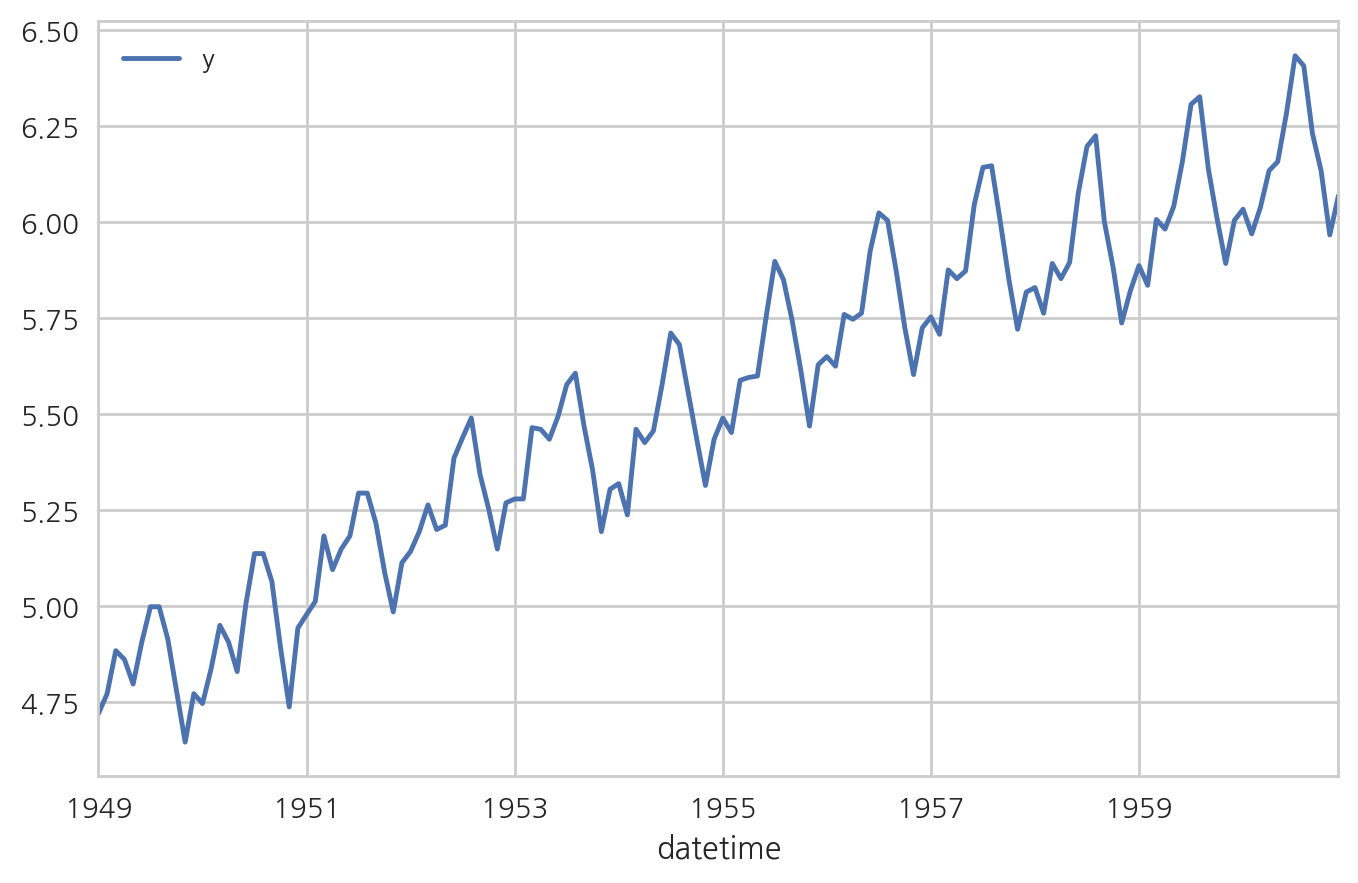

In [255]:
df.plot(x="datetime", y="y")
plt.show()

In [332]:
m = sm.tsa.SARIMAX(df.y.values, dmatrix("C(month) + 0", data=df), trend='c',
                   order=(0,1,1), seasonal_order=(1,0,0,12),
                   enforce_stationarity=False, enforce_invertibility=False)
r = m.fit()
print(r.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(1, 0, 0, 12)   Log Likelihood                 255.502
Date:                            Fri, 28 Jul 2017   AIC                           -479.005
Time:                                    15:51:45   BIC                           -431.488
Sample:                                         0   HQIC                          -459.697
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0073      0.002      2.939      0.003       0.002       0.012
x1            -0.0878      0.016   

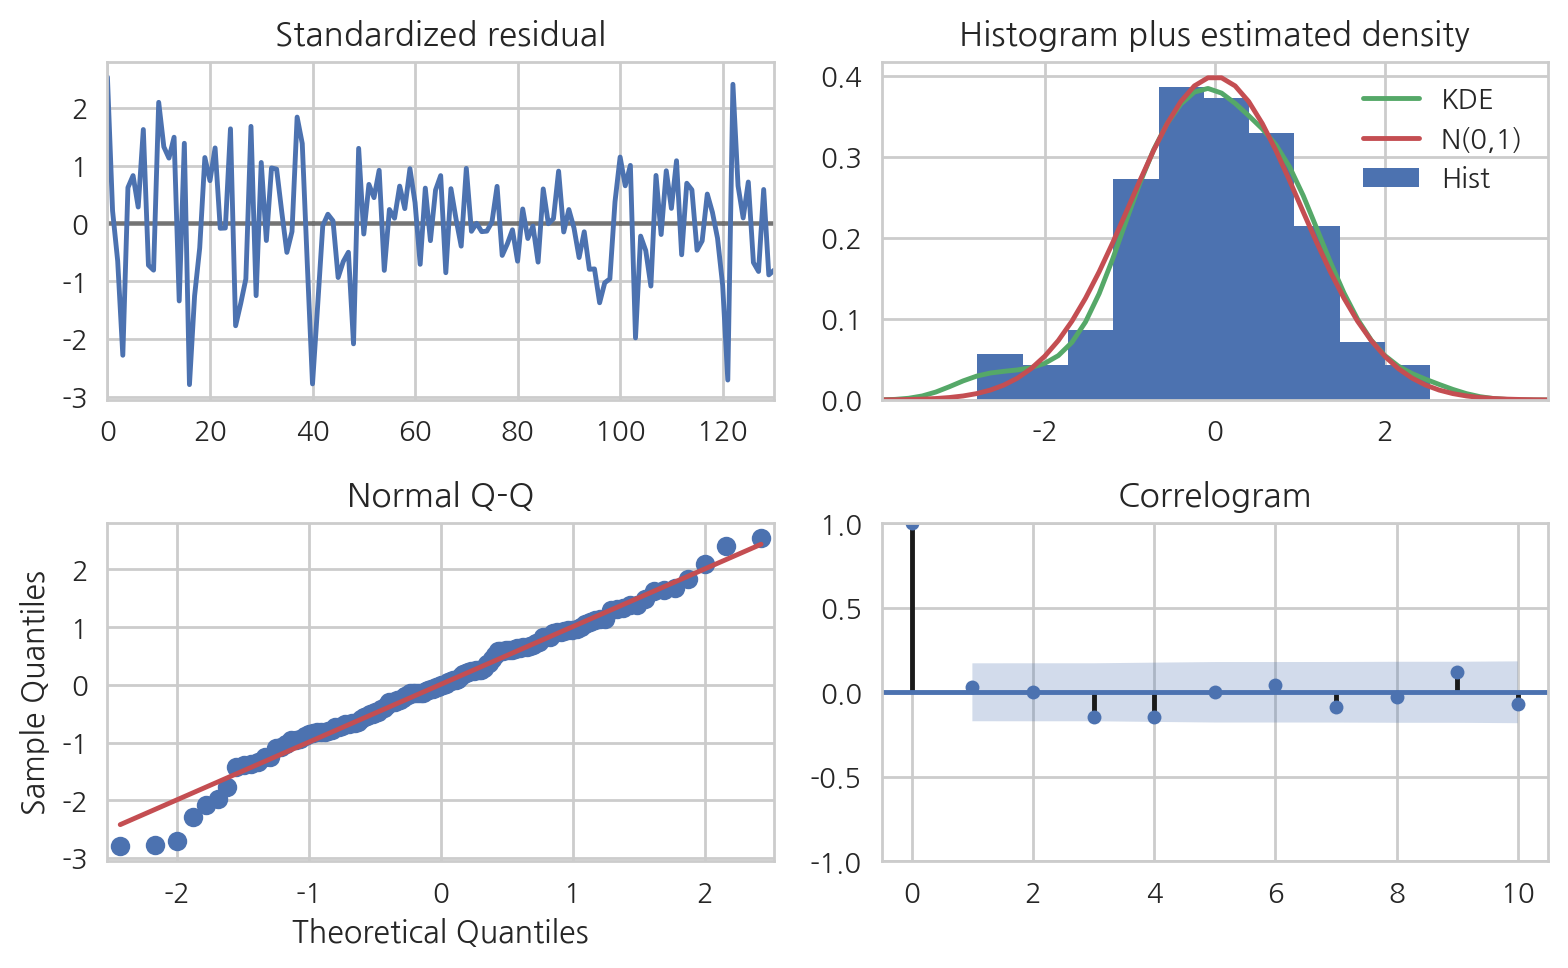

In [333]:
r.plot_diagnostics()
plt.tight_layout()
plt.show()

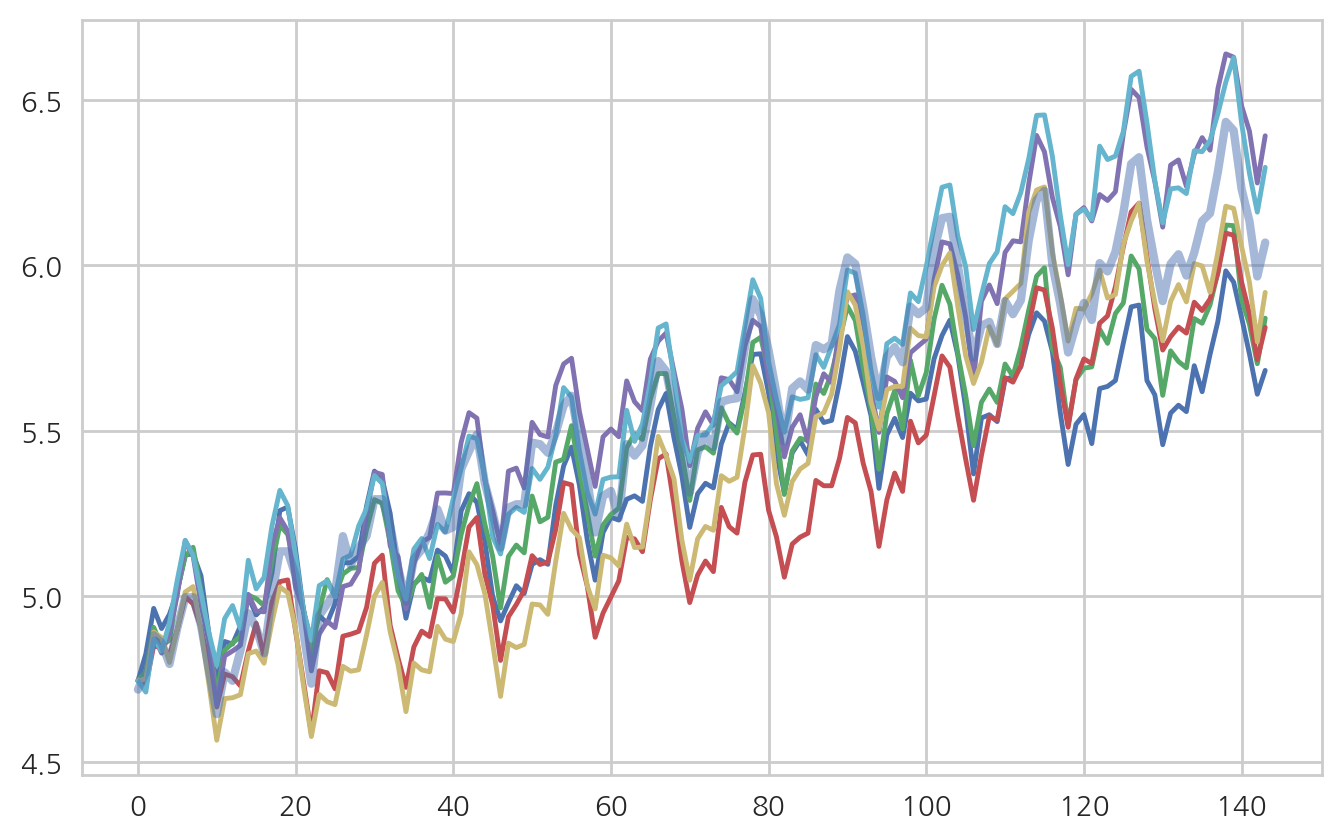

In [334]:
np.random.seed(0)
initial_state = r.filtered_state[:,12]
for i in range(6):
    plt.plot(r.simulate(len(df.y), initial_state=initial_state))
plt.plot(df.y.values, lw=3, alpha=0.5)
plt.show()